# Planet Amazon Image Classification - Machine Learning

The labels can broadly be broken into three groups: atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena. Each chip will have one and potentially more than one atmospheric label and zero or more common and rare labels.
The common labels in this data set are rainforest, agriculture, rivers, towns/cities, and roads. The overwhelming majority of the data set is labeled as "primary".

In this notebook we first import the data then we proceed to use a Random Forest model to generate label predictions to be as a baseline and a series of Convolutional Neural Nets with various architectures:
 - A baseline CNN
 - A baseline CNN with an additional layer of Batch Normalization
 - A CNN with Softmax Activation for Cloud Coverage Prediction
 - A baseline CNN using higher resolution grayscale images as input

## Importing the Data

In [1]:
#import modules
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import pickle
from IPython.display import display
from skimage import io
%matplotlib inline

# Define files and directories
#os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone2/')
         
# Create DataFrame with training labels
train_labels = pd.read_csv('../train_classes.csv')
#train_labels = pd.read_csv('/floyd/input/amazon_train_classes/train_classes.csv')

train_labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [2]:
#Extracting unique labels
labels = []
for tags in train_labels.tags.values:
    label = tags.split(' ')
    for subitem in label:
        if subitem not in labels:
            labels.append(subitem)

#One Hot encoding labels
for label in labels:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_labels.index = train_labels.image_name
train_labels

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
image_name,,,,,,,,,,,,,,,,,,,
train_0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
train_2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_40474,train_40474,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_40475,train_40475,cloudy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
train_40476,train_40476,agriculture clear primary,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
cloud_labels = train_labels[['haze','clear','cloudy','partly_cloudy']]
cloud_labels

,haze,clear,cloudy,partly_cloudy
image_name,,,,
train_0,1,0,0,0
train_1,0,1,0,0
train_2,0,1,0,0
train_3,0,1,0,0
train_4,0,1,0,0
...,...,...,...,...
train_40474,0,1,0,0
train_40475,0,0,1,0
train_40476,0,1,0,0


## Baseline Random Forest Model using average RGB values

In [4]:
#Load average RGB values calculated in the EDA notebook
mean_rgb_images_df = pd.read_csv('..\mean_RGB_images.csv', index_col=0)
mean_rgb_images_df.index.name = 'image_name'
mean_rgb_images_df

,R,G,B
image_name,,,
train_0,91.787384,109.347000,103.609146
train_1,65.639862,76.497375,64.301590
train_2,43.164474,58.039383,56.862000
train_3,51.411316,65.253769,53.972961
train_4,57.342377,45.253403,19.525055
...,...,...,...
train_40474,61.309784,68.352692,63.718872
train_40475,148.132324,151.763138,143.260849
train_40476,82.383011,64.913818,35.009766


In [5]:
#Adding back labels to average RGB data for each image
mean_rgb_images_df = mean_rgb_images_df.merge(train_labels.drop('image_name',axis=1), left_index=True, right_on='image_name')
mean_rgb_images_df.drop('tags', axis=1, inplace=True)

In [6]:
mean_rgb_images_df

,R,G,B,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
image_name,,,,,,,,,,,,,,,,,,,,
train_0,91.787384,109.347000,103.609146,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_1,65.639862,76.497375,64.301590,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
train_2,43.164474,58.039383,56.862000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_3,51.411316,65.253769,53.972961,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_4,57.342377,45.253403,19.525055,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_40474,61.309784,68.352692,63.718872,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_40475,148.132324,151.763138,143.260849,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
train_40476,82.383011,64.913818,35.009766,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
import time

#subset data for testing the code and finding best params
mean_rgb_images_subset = mean_rgb_images_df.iloc[:27000,:]

#Splitting target and features
X = mean_rgb_images_subset[['R','G','B']]
y = mean_rgb_images_subset.drop(['R','G','B'],axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

###########################################################################
# #Instantiate the model
# rfm = RandomForestClassifier()

# #Tuning parameters and performing cross-validation
# # Setup the hyperparameter grid
# n_estimators = np.arange(100, 400, 100)#number of trees in Forest
# max_depth = np.arange(1,12)#depth of trees
# param_grid = {'n_estimators': n_estimators, 'max_depth':max_depth}

# # Instantiate the GridSearchCV object: rf_cv
# rf_cv = GridSearchCV(rfm, param_grid, cv=5, scoring='f1_samples')

# #Fitting the model
# rf_cv.fit(X_train, y_train)

# print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_)) 
# print("Best score is {}".format(rf_cv.best_score_))

# Tuned Random Forest Parameters: {'max_depth': 10, 'n_estimators': 200}
# Best score is 0.7207079883079882

#####################################################################

start_time = time.time()
#Instantiate model with best parameters from GridSearchCV
rfm = RandomForestClassifier(max_depth=10, n_estimators=200)

#Fitting the model
rfm.fit(X_train, y_train)

y_pred = rfm.predict(X_test)

end_time = time.time()

# Scoring with F beta
print('F beta score:', fbeta_score(np.asarray(y_test), y_pred, beta=2, average='samples'))
print(str((end_time-start_time))+' secs')

F beta score: 0.7050780067269349
18.92734408378601 secs


C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score

resulting_metrics = pd.DataFrame(recall_score(y_test, y_pred, average=None))
resulting_metrics.index = labels
resulting_metrics.columns = ['Recall']
resulting_metrics["Precision"] = precision_score(y_test, y_pred, average=None)
resulting_metrics['F1'] = f1_score(y_test, y_pred, average=None)
resulting_metrics

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Recall,Precision,F1
haze,0.039813,0.515152,0.073913
primary,0.989165,0.955665,0.972127
agriculture,0.495345,0.657347,0.564962
clear,0.938593,0.831765,0.881956
water,0.026211,0.673469,0.050459
habitation,0.012618,0.727273,0.024806
road,0.275093,0.611570,0.379487
cultivation,0.000000,0.000000,0.000000
slash_burn,0.000000,0.000000,0.000000
cloudy,0.520958,0.746781,0.613757


## Deep Learning with Convolutional Neural Nets

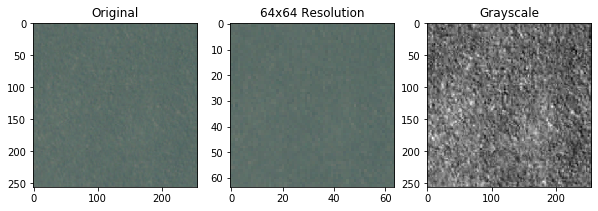

In [9]:
from skimage.transform import resize
from skimage.color import rgb2gray

#Write function to get a specific image

def load_image(file_name, fig_type='jpg', size=256, n_channels=3):
    
    """Loads the requested image resized and converted to gray if n_channels == 1 specified"""
    
    img_path = ('../train-{}/{}.{}').format(fig_type,file_name,fig_type)
    #img_path = ('/floyd/input/amazon_images/{}.{}').format(file_name,fig_type)
    img = io.imread(img_path)
    img = resize(img, (size,size,3), mode='constant')
    if n_channels == 1:
        img = rgb2gray(img)[:, :, np.newaxis]
    
    return img

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

ax = axes.ravel()
ax[0].imshow(load_image('train_0'))
ax[0].set_title("Original")
ax[1].imshow(load_image('train_0', size=64))
ax[1].set_title("64x64 Resolution")
ax[2].imshow(load_image('train_0', n_channels=1)[:,:,0], cmap=plt.cm.gray)
ax[2].set_title("Grayscale");

In [10]:
#Create a lookup dictionary containing the labels for each image sample, we will use this on our data generator object

labels_dict={}
labels_array = np.array(train_labels.iloc[:,-17:])

for i, sample in enumerate(train_labels.index):
    labels_dict[sample] = labels_array[i]

cloud_labels_dict={}
cloud_labels_array = np.array(cloud_labels.iloc[:,-17:])

for i, sample in enumerate(cloud_labels.index):
    cloud_labels_dict[sample] = cloud_labels_array[i]

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

C:\Users\isado\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
#RAM size limitation makes it so we have to process our data in mini-batches using a data generator

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(ID, size=self.dim[0], n_channels=self.n_channels)

            # Store class
            y[i] = self.labels[ID]

        return X, np.array(y)

In [13]:
#Write function to get f1-score metric for Keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Baseline CNN Neural Net
 - Batch size = 256
 - Training set size = 20000
 - Validation set size = 7000
 - Image Res: 64x64 RGB
 - Early stopping: validation loss with patience of 5
 - Metric: F1 score

In [14]:
# Parameters
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
#modelCheckpoint = ModelCheckpoint('best_amazonimages_model.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(train_labels.index[0:20000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[20000:27000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/50
77/78 [============================>.] - ETA: 3s - loss: 0.3142 - accuracy: 0.8833 - f1_m: 0.6183 - precision_m: 0.7326 - recall_m: 0.5414

78/78 [==============================] - 306s 4s/step - loss: 0.3135 - accuracy: 0.8835 - f1_m: 0.6187 - precision_m: 0.7337 - recall_m: 0.5414 - val_loss: 0.2369 - val_accuracy: 0.9089 - val_f1_m: 0.6717 - val_precision_m: 0.8588 - val_recall_m: 0.5516
Epoch 2/50
78/78 [==============================] - 279s 4s/step - loss: 0.2462 - accuracy: 0.9073 - f1_m: 0.6718 - precision_m: 0.8361 - recall_m: 0.5619 - val_loss: 0.2273 - val_accuracy: 0.9140 - val_f1_m: 0.6893 - val_precision_m: 0.8855 - val_recall_m: 0.5644
Epoch 3/50
78/78 [==============================] - 277s 4s/step - loss: 0.2300 - accuracy: 0.9131 - f1_m: 0.6977 - precision_m: 0.8463 - recall_m: 0.5943 - val_loss: 0.2028 - val_accuracy: 0.9192 - val_f1_m: 0.7228 - val_precision_m: 0.8592 - val_recall_m: 0.6240
Epoch 4/50
78/78 [==============================] - 279s 4s/step 

In [12]:
# save model and architecture to a h5 file
#model.save("baseline_model_20000n.h5")
#print("Saved model to disk")

Saved model to disk


In [15]:
#load model
from keras.models import load_model

model = load_model("baseline_model_20000n.h5", custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})

model.summary()

Instructions for updating:
Use tf.cast instead.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 57, 57, 32)        6176      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        131136    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_

In [16]:
def plot_loss(loss,val_loss):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

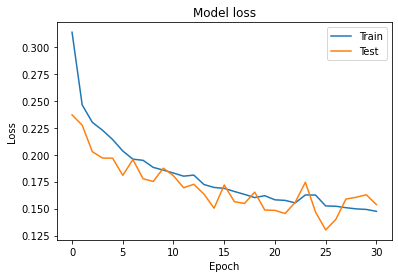

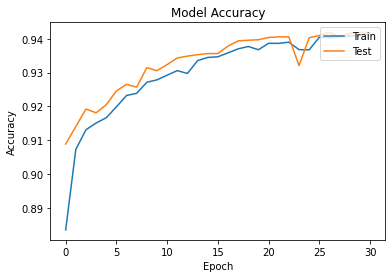

In [14]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [18]:
# Evaluating model using test set
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[35000:40376]#test size needs to be an exact multiple of the batch size specified by the data generator

test_generator = DataGenerator(test_set, labels_dict, **params)

# make predictions on the testing images
preds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

21/21 [==============================] - 112s 5s/step


In [19]:
truelabels = train_labels.loc[test_set].iloc[:,-17:].values

In [20]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve

def class_f1_calc(predictions, truelabels):
    "Returns a dataframe with f1 score values broken down per class for various Thresholds"

    #Initialize a dictionary for accuracy, this dictionary will breakdown accuracy per threshold
    class_f1 = {}
    #Initialize class predictions with all zeros
    preds_threshold = np.zeros(truelabels.shape)

    for threshold in np.arange(0,1.05,0.05):

        #initialize dictionary to hold accuracy per threshold
        class_f1['Threshold: {:.2f}'.format(threshold)] = {}
        i = 0

        for sample in predictions:
            preds_threshold[i] = [1 if class_proba>threshold else 0 for class_proba in sample]
            i += 1

        #flatten array before calling accuracy score to get overall acuracy metric
        class_f1['Threshold: {:.2f}'.format(threshold)]['Overall'] = f1_score(np.ndarray.flatten(truelabels), np.ndarray.flatten(preds_threshold))

        for column_idx in range(len(labels)):
            class_predictions = preds_threshold[:,column_idx]
            true_labels_class = truelabels[:,column_idx]
            class_f1['Threshold: {:.2f}'.format(threshold)][labels[column_idx]] = f1_score(np.ndarray.flatten(true_labels_class), np.ndarray.flatten(class_predictions))

    return (pd.DataFrame.from_dict(class_f1).T)

In [21]:
baseline_model_performance = class_f1_calc(preds, truelabels)
baseline_model_performance

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\isado\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.291025,0.124232,0.964062,0.471642,0.827609,0.302762,0.162051,0.329397,0.204109,0.013941,0.090196,0.306772,0.002249,0.047991,0.017954,0.014795,0.016458,0.004544
Threshold: 0.05,0.647688,0.450366,0.964527,0.616198,0.891343,0.360140,0.331496,0.477780,0.327394,0.033333,0.644351,0.642259,0.080000,0.182819,0.343434,0.119403,0.040541,0.000000
Threshold: 0.10,0.699472,0.516546,0.965178,0.667216,0.904944,0.391913,0.370844,0.523923,0.356104,0.000000,0.704545,0.770300,0.000000,0.230937,0.384000,0.000000,0.000000,0.000000
Threshold: 0.15,0.734691,0.568574,0.966283,0.695576,0.915328,0.417317,0.410205,0.551213,0.391940,0.000000,0.706294,0.823814,0.000000,0.236934,0.378947,0.000000,0.000000,0.000000
Threshold: 0.20,0.764731,0.604926,0.967867,0.714513,0.926071,0.439660,0.440513,0.577301,0.435008,0.000000,0.717949,0.842850,0.000000,0.198895,0.394737,0.000000,0.000000,0.000000
Threshold: 0.25,0.788110,0.633621,0.969744,0.727917,0.933251,0.457815,0.482397,0.593320,0.439735,0.000000,0.711799,0.844398,0.000000,0.148649,0.347826,0.000000,0.000000,0.000000
Threshold: 0.30,0.803690,0.656613,0.971140,0.740741,0.938210,0.454748,0.463850,0.600699,0.398619,0.000000,0.713147,0.842834,0.000000,0.000000,0.258065,0.000000,0.000000,0.000000
Threshold: 0.35,0.814639,0.667500,0.974054,0.749681,0.940214,0.413381,0.424883,0.618471,0.259128,0.000000,0.702479,0.837765,0.000000,0.000000,0.210526,0.000000,0.000000,0.000000
Threshold: 0.40,0.818308,0.655126,0.975567,0.758001,0.942278,0.325937,0.287051,0.626804,0.052388,0.000000,0.695464,0.829646,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000
Threshold: 0.45,0.817449,0.631579,0.975801,0.759424,0.944055,0.269263,0.094675,0.613369,0.000000,0.000000,0.665105,0.826038,0.000000,0.000000,0.188679,0.000000,0.000000,0.000000


## CNN Neural Net with Batch Normalization
 - Batch size = 512
 - Training set size = 20000
 - Validation set size = 7000
 - Image Res: 64x64 RGB
 - Early stopping: validation loss with patience of 5
 - Added batch normalization

In [ ]:
from keras.layers import BatchNormalization

# Parameters
params = {'dim': (64,64),
          'batch_size': 512,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
#modelCheckpoint = ModelCheckpoint('best_amazonimages_model_batchnorm.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(train_labels.index[0:20000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[20000:27000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=2)

In [24]:
# save model and architecture to a tf file
#model.save("batch_norm_model_20000n.tf")
#print("Saved model to disk")

Saved model to disk


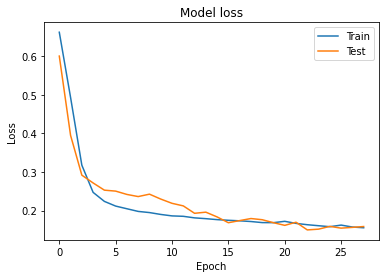

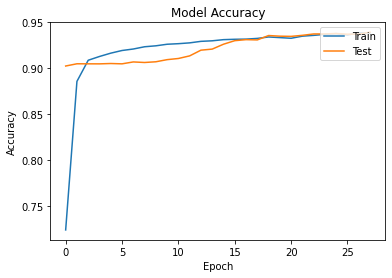

In [23]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [25]:
# Evaluating model using test set
#make predictions
preds_batchnorm = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

10/10 [==============================] - 32s 3s/step


In [26]:
batchnorm_model_performance = class_f1_calc(preds_batchnorm, truelabels)
batchnorm_model_performance

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.252391,0.119423,0.632553,0.378763,0.570889,0.269395,0.150956,0.287293,0.193630,0.015402,0.078208,0.261460,0.001559,0.044577,0.017638,0.020008,0.020737,0.00311
Threshold: 0.05,0.467848,0.378824,0.632707,0.444948,0.597493,0.274703,0.283828,0.369174,0.280193,0.000000,0.424508,0.436469,0.000000,0.106667,0.316832,0.000000,0.000000,0.00000
Threshold: 0.10,0.500839,0.421199,0.633294,0.474931,0.602265,0.327709,0.312958,0.400837,0.300057,0.000000,0.426471,0.497348,0.000000,0.013793,0.376812,0.000000,0.000000,0.00000
Threshold: 0.15,0.515626,0.440780,0.633629,0.488230,0.606794,0.335324,0.323587,0.415941,0.319889,0.000000,0.410526,0.519846,0.000000,0.000000,0.412698,0.000000,0.000000,0.00000
Threshold: 0.20,0.522913,0.440514,0.633868,0.494149,0.609195,0.326670,0.326711,0.435347,0.300088,0.000000,0.405556,0.515868,0.000000,0.000000,0.393443,0.000000,0.000000,0.00000
Threshold: 0.25,0.525415,0.436242,0.634205,0.495502,0.610837,0.304594,0.314746,0.427807,0.241953,0.000000,0.372781,0.512178,0.000000,0.000000,0.315789,0.000000,0.000000,0.00000
Threshold: 0.30,0.524468,0.429338,0.634276,0.495690,0.613229,0.228972,0.304527,0.429538,0.145049,0.000000,0.351515,0.509581,0.000000,0.000000,0.285714,0.000000,0.000000,0.00000
Threshold: 0.35,0.519639,0.416206,0.634431,0.492481,0.615385,0.165639,0.253776,0.418465,0.049844,0.000000,0.338462,0.498919,0.000000,0.000000,0.222222,0.000000,0.000000,0.00000
Threshold: 0.40,0.514072,0.400763,0.634406,0.479281,0.616130,0.122180,0.210702,0.397468,0.006515,0.000000,0.321767,0.488270,0.000000,0.000000,0.188679,0.000000,0.000000,0.00000
Threshold: 0.45,0.507056,0.377734,0.634367,0.462226,0.615278,0.085938,0.171429,0.363151,0.003268,0.000000,0.306709,0.476900,0.000000,0.000000,0.117647,0.000000,0.000000,0.00000


## CNN Neural Net with Softmax Activation for Cloud Coverage Prediction
 - Batch size = 256
 - Training set size = 20000
 - Validation set size = 7000
 - Image Res: 64x64 RGB
 - Early stopping: validation loss with patience of 5
 - Metric: F1 score

In [10]:
# Parameters
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 4,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(train_labels.index[0:20000], cloud_labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[20000:27000], cloud_labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(4, activation='softmax', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [11]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/50
77/78 [============================>.] - ETA: 3s - loss: 0.3850 - accuracy: 0.8369 - f1_m: 0.6060 - precision_m: 0.6721 - recall_m: 0.5658
Epoch 1/50
78/78 [==============================] - 306s 4s/step - loss: 0.3847 - accuracy: 0.8370 - f1_m: 0.6063 - precision_m: 0.6737 - recall_m: 0.5652 - val_loss: 0.3283 - val_accuracy: 0.8457 - val_f1_m: 0.6081 - val_precision_m: 0.8314 - val_recall_m: 0.4800
Epoch 2/50
78/78 [==============================] - 266s 3s/step - loss: 0.3347 - accuracy: 0.8611 - f1_m: 0.6762 - precision_m: 0.8087 - recall_m: 0.5837 - val_loss: 0.3017 - val_accuracy: 0.8746 - val_f1_m: 0.7174 - val_precision_m: 0.8203 - val_recall_m: 0.6377
Epoch 3/50
78/78 [==============================] - 262s 3s/step - loss: 0.3132 - accuracy: 0.8725 - f1_m: 0.7148 - precision_m: 0.8103 - recall_m: 0.6413 - val_loss: 0.3234 - val_accuracy: 0.8771 - val_f1_m: 0.7281 - val_precision_m: 0.8136 - val_recall_m: 0.6592
Epoch 4/50
78/78 [==============================] - 263

In [64]:
# save model and architecture to a tf file
model.save("cloudconditions_model_20000n.tf")
#print("Saved model to disk")

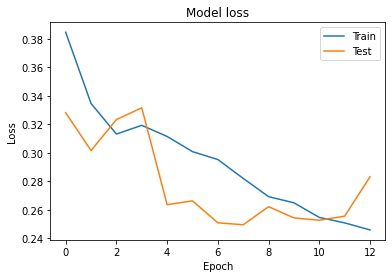

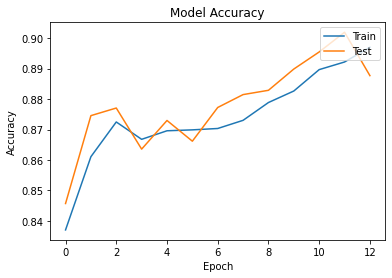

In [12]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [16]:
# Evaluating model using test set
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 4,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[35000:40376]#test size needs to be an exact multiple of the batch size specified by the data generator

test_generator = DataGenerator(test_set, cloud_labels_dict, **params)

# make predictions on the testing images
preds_clouds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

21/21 [==============================] - 54s 3s/step


In [61]:
clouds_class_pred = np.zeros(preds_clouds.shape)
clouds_labels_test = cloud_labels[35000:40376].values
i = 0
for sample in preds_clouds:
    clouds_class_pred[i,np.argmax(sample)] = 1
    i += 1

# #flatten array before calling accuracy score to get overall acuracy metric
print('F1 Scores\nOverall:',f1_score(np.ndarray.flatten(clouds_labels_test), np.ndarray.flatten(clouds_class_pred)))

for column_idx in range(4):
    class_predictions = clouds_class_pred[:,column_idx]
    clouds_labels_test_class = clouds_labels_test[:,column_idx]
    class_f1 = f1_score(np.ndarray.flatten(clouds_labels_test_class), np.ndarray.flatten(class_predictions))
    print(cloud_labels.columns[column_idx], class_f1)

F1 Scores
Overall: 0.7648809523809522
haze 0.44049733570159855
clear 0.8710369487485101
cloudy 0.5961538461538463
partly_cloudy 0.2799061767005473


## CNN Neural Net - higher resolution grayscale images
 - Batch size = 256
 - Training set size = 20000
 - Validation set size = 7000
 - Image Res: 128x128 Grayscale
 - Early stopping: validation loss with patience of 5
 - Metric: F1 score
 - Added batch normalization

In [66]:
from keras.layers import BatchNormalization

# Parameters
params = {'dim': (128,128),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 1,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping


# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(train_labels.index[0:20000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[20000:27000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(128, 128, 1)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(128, 128, 1)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

#batch normalization
model.add(BatchNormalization())

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

# Train model on dataset
grayscale_history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/50
78/78 [==============================] - 268s 3s/step - loss: 0.5567 - accuracy: 0.8102 - f1_m: 0.5457 - precision_m: 0.5520 - recall_m: 0.5911 - val_loss: 0.3723 - val_accuracy: 0.9048 - val_f1_m: 0.6682 - val_precision_m: 0.8142 - val_recall_m: 0.5667
Epoch 2/50
78/78 [==============================] - 241s 3s/step - loss: 0.2744 - accuracy: 0.9104 - f1_m: 0.6843 - precision_m: 0.8458 - recall_m: 0.5750 - val_loss: 0.2638 - val_accuracy: 0.9047 - val_f1_m: 0.6676 - val_precision_m: 0.8133 - val_recall_m: 0.5664
Epoch 3/50
78/78 [==============================] - 242s 3s/step - loss: 0.2205 - accuracy: 0.9141 - f1_m: 0.7064 - precision_m: 0.8362 - recall_m: 0.6122 - val_loss: 0.2363 - val_accuracy: 0.9063 - val_f1_m: 0.6714 - val_precision_m: 0.8243 - val_recall_m: 0.5666
Epoch 4/50
78/78 [==============================] - 242s 3s/step - loss: 0.2075 - accuracy: 0.9161 - f1_m: 0.7178 - precision_m: 0.8317 - recall_m: 0.6319 - val_loss: 0.2382 - val_accuracy: 0.9096 - val_f1

In [69]:
# save model and architecture to an tf file
model.save("grayscale_model_20000n.tf")
print("Saved model to disk")

Saved model to disk


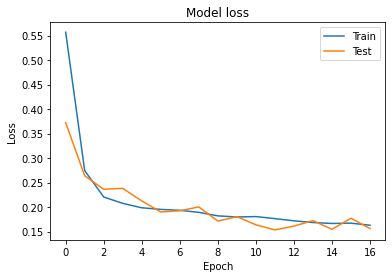

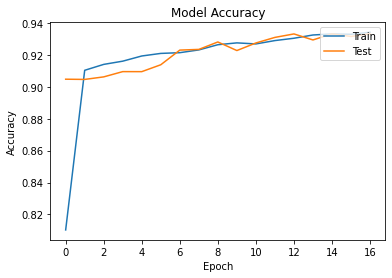

In [70]:
# Plot train vs test loss during training
plot_loss(grayscale_history.history['loss'], grayscale_history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(grayscale_history.history['accuracy'], grayscale_history.history['val_accuracy'])

In [17]:
# Evaluating model using test set
params_gray = {'dim': (128,128),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 1,
          'shuffle': False}

test_set = train_labels.index[35000:40376]

test_generator_gray = DataGenerator(test_set, labels_dict, **params_gray)

model = load_model('grayscale_model_20000n.tf', custom_objects={'f1_m': f1_m, 'precision_m':precision_m, 'recall_m':recall_m})

preds_grayscale = model.predict_generator(test_generator_gray,steps=len(test_set)//params['batch_size'],verbose=1)

21/21 [==============================] - 97s 5s/step


In [74]:
grayscale_model_performance = class_f1_calc(preds_grayscale, truelabels)
grayscale_model_performance

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.289372,0.123560,0.964062,0.471642,0.827609,0.302762,0.162051,0.329397,0.204109,0.013671,0.089892,0.306772,0.00223,0.047930,0.017699,0.014404,0.016236,0.004454
Threshold: 0.05,0.620338,0.406213,0.964806,0.579838,0.857111,0.348261,0.346078,0.445802,0.304315,0.000000,0.466258,0.489985,0.00000,0.053191,0.210526,0.000000,0.000000,0.000000
Threshold: 0.10,0.678005,0.560731,0.965271,0.615268,0.870045,0.383376,0.420102,0.501561,0.344936,0.000000,0.626113,0.570028,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.15,0.713140,0.576714,0.966203,0.647249,0.876334,0.400274,0.445748,0.545126,0.361905,0.000000,0.662675,0.647487,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.20,0.743013,0.540613,0.966663,0.669938,0.884453,0.407023,0.467236,0.583758,0.338373,0.000000,0.597647,0.684058,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.25,0.762459,0.455574,0.967224,0.683148,0.890154,0.417545,0.424883,0.599096,0.069666,0.000000,0.564885,0.707734,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.30,0.774263,0.303371,0.967861,0.696450,0.895034,0.302721,0.376569,0.614094,0.000000,0.000000,0.558747,0.712158,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.35,0.779280,0.142549,0.968323,0.701827,0.902023,0.074557,0.301887,0.620148,0.000000,0.000000,0.490251,0.716024,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.40,0.781431,0.084507,0.969074,0.705068,0.909387,0.004162,0.252560,0.599092,0.000000,0.000000,0.459302,0.713071,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.45,0.781232,0.000000,0.969150,0.701484,0.912911,0.000000,0.222222,0.578047,0.000000,0.000000,0.434524,0.706733,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
